## Exploratory Data Analysis

Loading libraries

In [1]:
import json
import ijson
import logging

import numpy as np

from decimal import Decimal
from pathlib import Path
from typing import List, Tuple

from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *

Setting up Logger

In [2]:
# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

Loading the `ConfigParser` for paths

In [3]:
from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

In [4]:
# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

Loading the Meta Donor DataFrame

In [5]:
meta_donor_csv_pth = PROCESSED_DONORS_GE_PATH / Path("meta_donor.csv")
meta_donor_df = load_df_from_csv(meta_donor_csv_pth)

In [6]:
meta_donor_df.head(5)

,brain_region,gene_id,gene_expression_values
0,4012,2,"[1.58747780630413, 7.567907786636231, 1.495682..."
1,4012,3,"[5.11909080343638, 9.66921569197332, 10.081154..."
2,4012,6,"[1.83564765363665, 1.4949501777457102, 5.94151..."
3,4012,7,"[1.79544247551668, 8.01919162976325, 1.4730663..."
4,4012,9,"[2.20842768312641, 2.53387577054784, 3.1338710..."


Converting the gene_expression_values from a stored string to a list

In [7]:
meta_donor_df["gene_expression_values"]=meta_donor_df["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df["gene_expression_values"][0][0])

1.58747780630413


In [8]:
meta_donor_df.head(5)

,brain_region,gene_id,gene_expression_values
0,4012,2,"[1.58747780630413, 7.567907786636231, 1.495682..."
1,4012,3,"[5.11909080343638, 9.66921569197332, 10.081154..."
2,4012,6,"[1.83564765363665, 1.4949501777457102, 5.94151..."
3,4012,7,"[1.79544247551668, 8.01919162976325, 1.4730663..."
4,4012,9,"[2.20842768312641, 2.53387577054784, 3.1338710..."


Exploring Data Scale

In [9]:
meta_donor_df.describe()

,brain_region,gene_id
count,6.185948e+06,6.185948e+06
mean,5.518038e+03,3.435682e+05
std,2.175165e+03,4.467000e+05
min,4.012000e+03,2.000000e+00
25%,4.191500e+03,1.055500e+04
50%,4.475000e+03,7.751200e+04
75%,4.901500e+03,1.004858e+06
max,1.300800e+04,1.022429e+06


In [10]:
meta_donor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6185948 entries, 0 to 6185947
Data columns (total 3 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   brain_region            int64 
 1   gene_id                 int64 
 2   gene_expression_values  object
dtypes: int64(2), object(1)
memory usage: 141.6+ MB


Using Utility functions to extract some insights about the numbers

In [11]:
# Data Scale
total_number_of_samples = get_total_number_of_samples(meta_donor_df)
logger.info(f"Number of Total Samples: {total_number_of_samples}")

number_of_br = get_total_number_of_br(meta_donor_df)
logger.info(f"Number of Total Brain Regions: {number_of_br}")

number_of_ge_per_br = get_number_of_genes_per_br(meta_donor_df)
logger.info(f"Number of Genes ids per Brain Region: \n{number_of_ge_per_br}")

number_of_samples_per_br = get_number_of_samples_per_br(meta_donor_df)
logger.info(f"Number of Samples per Brain Region:\n{number_of_samples_per_br}")

number_of_samples_per_br_ge = get_number_of_samples_per_br_ge(meta_donor_df)
logger.info(f"Number of Samples per Brain Region-Gene Id pair:\n{number_of_samples_per_br_ge}")

br_ids = get_br_list(meta_donor_df)
logger.info(f"List of Brain Regions:\n{br_ids}")

sample = get_br_ge_sample(meta_donor_df, 4012, 2)
logger.info(f"Sample of Brain Region-Gene Id pair\n{sample}")


Number of Total Samples: 155883296
Number of Total Brain Regions: 212
Number of Genes ids per Brain Region: 
brain_region
4012     29179
4013     29179
4014     29179
4015     29179
4022     29179
         ...  
10145    29179
10148    29179
10151    29179
13005    29179
13008    29179
Name: gene_id, Length: 212, dtype: int64
Number of Samples per Brain Region:
[645601, 1115129, 1056438, 821674, 58691, 2523713, 2347640, 1936803, 1760730, 880365, 469528, 1056438, 1173820, 1232511, 293455, 293455, 880365, 352146, 410837, 117382, 821674, 704292, 762983, 1056438, 1232511, 762983, 586910, 1115129, 1349893, 939056, 997747, 997747, 1056438, 1173820, 1291202, 58691, 117382, 1584657, 1643348, 2112876, 2406331, 1936803, 1408584, 1760730, 1173820, 1056438, 1115129, 645601, 469528, 528219, 1056438, 1115129, 939056, 1702039, 1467275, 997747, 821674, 762983, 880365, 762983, 645601, 1819421, 2054185, 1056438, 997747, 293455, 352146, 1525966, 1173820, 1467275, 1408584, 1115129, 1232511, 1173820, 12325

In [12]:
sum(number_of_samples_per_br)

155883296

Sanity checks

In [13]:
logger.info(f"Number of Samples / list of Brain regions = Average plotted on graph {total_number_of_samples/len(br_ids)}")

logger.info(f"Total Number of Samples = Sum of Samples per BR {total_number_of_samples == sum(number_of_samples_per_br)}")

# logger.info(f"Total Number of Samples = Sum of Samples per BR and Gene ID{total_number_of_samples == sum(number_of_samples_per_br_ge["sample_count"].tolist())}")

ge_ids = get_ge_list(meta_donor_df)
logger.info(f"Unique Gene Ids are in Every brain Region{len(ge_ids)*len(br_ids) == len(number_of_samples_per_br_ge)}")

Number of Samples / list of Brain regions = Average plotted on graph 735298.5660377359
Total Number of Samples = Sum of Samples per BR True
Unique Gene Ids are in Every brain RegionTrue


In [20]:
df = number_of_samples_per_br_ge.copy()
df['brain_region'].max()

13008

In [21]:
# Combine 'gene_id' and 'brain_region' into a single column for the x-axis
# df['gene.region'] = (df['gene_id'].astype(str) + '.' + df['brain_region'].astype(str))
df['gene_region'] = df['gene_id'] + df['brain_region'] / 10**(df['brain_region'].astype(str).str.len())
df['gene_region'] = df['gene_region'].round(5)

df

,brain_region,gene_id,sample_count,gene_region
0,4012,2,22,2.401200e+00
1,4012,3,44,3.401200e+00
2,4012,6,77,6.401200e+00
3,4012,7,22,7.401200e+00
4,4012,9,44,9.401200e+00
...,...,...,...,...
6185943,13008,1021983,4,1.021983e+06
6185944,13008,1021987,4,1.021987e+06
6185945,13008,1022208,4,1.022208e+06
6185946,13008,1022393,8,1.022393e+06


In [22]:
df['gene_region'][len(df)-1]

1022429.13008

In [23]:
print(df['gene_region'].head())  # Check the structure of the gene.region column
print(df['sample_count'].head()) 

0    2.4012
1    3.4012
2    6.4012
3    7.4012
4    9.4012
Name: gene_region, dtype: float64
0    22
1    44
2    77
3    22
4    44
Name: sample_count, dtype: int64


In [21]:
len(number_of_samples_per_br_ge)

6185948

In [28]:
def get_ge_list(df:pd.DataFrame) -> List[int]:
    """
        Get a list of Gene Ids available.
    """
    return df["gene_id"].unique().tolist()

In [15]:
import matplotlib
matplotlib.use('Agg')

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
    
x = df['gene_region'].astype(str)
y = df['sample_count']
plt.xlabel("GeneId.BrainRegion")
plt.ylabel("Number of Samples")
plt.title("GeneId.BrainRegion Number of Samples")
plt.scatter(x, y)
plt.savefig(PLOTS_PTH / Path("yabdany.png"), dpi=300, bbox_inches='tight')


: 

KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>

In [28]:
import datashader as ds
import datashader.transfer_functions as tf
import pandas as pd

# # Simulate large data
# df = pd.DataFrame({'category': np.random.randint(1, 100_000, size=6_000_000)})
# df = number_of_samples_per_br_ge.copy()
x = df['gene_region'].astype(str)
y = df['sample_count']
# # Aggregate counts
df.head(5)

,brain_region,gene_id,sample_count,gene_region
0,4012,2,22,2.4012
1,4012,3,44,3.4012
2,4012,6,77,6.4012
3,4012,7,22,7.4012
4,4012,9,44,9.4012


In [ ]:
import vaex
import bqplot as bq
import ipywidgets as widgets

# Load the CSV file
data = vaex.from_pandas(df)

# Calculate histogram data for a specific column, e.g., 'column_name'
bins = 50  # Number of bins
# counts, edges = data.histogram(data['column_name'], bins=bins)

# Prepare data for the bar plot
bin_centers = (data['sample_count'][:-1] + data['sample_count'][1:]) / 2  # Calculate bin centers for bar positioning

# Create the bqplot bar plot
x_scale = bq.LinearScale()
y_scale = bq.LinearScale()

bars = bq.Bars(x=bin_centers, y=data['gene_region'], scales={'x': x_scale, 'y': y_scale}, colors=['blue'])

# Set up the figure
x_axis = bq.Axis(scale=x_scale, label='Value')
y_axis = bq.Axis(scale=y_scale, orientation='vertical', label='Frequency')

fig = bq.Figure(marks=[bars], axes=[x_axis, y_axis])
fig.title = 'Bar Plot (Histogram)'
fig.layout.width = '800px'
fig.layout.height = '400px'

# Display the figure
widgets.VBox([fig])

In [34]:
# Create a Canvas object for the bar plot
canvas = ds.Canvas(plot_width=500, plot_height=300, x_range=(0, len(df["gene_region"])//2), y_range=(0, max(df["sample_count"])))

# Aggregate data into bins
agg = canvas.line(df, x='gene_region', y='sample_count', agg=ds.mean('sample_count'))

# Convert the aggregated data to an image
img = tf.shade(agg, cmap=["#FF000#"])
img.to_pil().show()

In [27]:
# Create Datashader Canvas
canvas = ds.Canvas(plot_width=1000, plot_height=400)
agg = canvas.line(pd.DataFrame({'x': x, 'y': y}), 'x', 'y')
img = tf.shade(agg)
img.to_pil().show()

In [68]:
import PyGnuplot as gp 
f1 = gp()
x = df['gene_region'].to_numpy()
y = df['sample_count'].to_numpy()
data = [x, y]
f1.a("plot x")

TypeError: 'module' object is not callable

### Failed attempts for plotting due to memory: 

In [47]:
vaex_df = vaex.from_pandas(df)

In [60]:
import vaex.jupyter.model as vjm

import numpy as np
import matplotlib.pyplot as plt

In [49]:
gene_region_axis = vjm.Axis(df=vaex_df, expression=vaex_df.gene_region, shape=140)
sample_count_axis = vjm.Axis(df=vaex_df, expression=vaex_df.sample_count, shape=100)
sample_count_axis

Axis(bin_centers=None, exception=None, expression=sample_count, max=None, min=None, shape=100, shape_default=64, slice=None, status=Status.NO_LIMITS)

In [50]:
await vaex.jupyter.gather()  # wait until Vaex is done with all background computation
sample_count_axis

Axis(bin_centers=[  27.875   81.625  135.375  189.125  242.875  296.625  350.375  404.125
  457.875  511.625  565.375  619.125  672.875  726.625  780.375  834.125
  887.875  941.625  995.375 1049.125 1102.875 1156.625 1210.375 1264.125
 1317.875 1371.625 1425.375 1479.125 1532.875 1586.625 1640.375 1694.125
 1747.875 1801.625 1855.375 1909.125 1962.875 2016.625 2070.375 2124.125
 2177.875 2231.625 2285.375 2339.125 2392.875 2446.625 2500.375 2554.125
 2607.875 2661.625 2715.375 2769.125 2822.875 2876.625 2930.375 2984.125
 3037.875 3091.625 3145.375 3199.125 3252.875 3306.625 3360.375 3414.125
 3467.875 3521.625 3575.375 3629.125 3682.875 3736.625 3790.375 3844.125
 3897.875 3951.625 4005.375 4059.125 4112.875 4166.625 4220.375 4274.125
 4327.875 4381.625 4435.375 4489.125 4542.875 4596.625 4650.375 4704.125
 4757.875 4811.625 4865.375 4919.125 4972.875 5026.625 5080.375 5134.125
 5187.875 5241.625 5295.375 5349.125], exception=None, expression=sample_count, max=5376.0, min=1.0, shape=

In [51]:
vaex_df

#,brain_region,gene_id,sample_count,gene_region
0,4012,2,22,2.4012
1,4012,3,44,3.4012
2,4012,6,77,6.4012
3,4012,7,22,7.4012
4,4012,9,44,9.4012
...,...,...,...,...
"6,185,943",13008,1021983,4,1021983.13008
"6,185,944",13008,1021987,4,1021987.13008
"6,185,945",13008,1022208,4,1022208.13008
"6,185,946",13008,1022393,8,1022393.13008


In [64]:
# Example DataFrame
df___ = vaex.from_arrays(x=df['gene_region'].to_numpy(), y=df['sample_count'].to_numpy())
df___.plot.backend = 'plt'
# Plot the two columns against each other
df___.plot(x='x', y='y')

AttributeError: 'method' object has no attribute 'backend'

In [52]:
data_array_widget = vaex_df.widget.data_array(axes=[sample_count_axis, gene_region_axis], selection=[None, 'default'])
data_array_widget  # being the last expression in the cell, Jupyter  will 'display' the widget

DataArray(children=[Container(children=[ProgressCircularNoAnimation(color='#9ECBF5', size=30, text='', value=1…

In [46]:
await vaex.jupyter.gather()
# get a reference to the xarray DataArray object
data_array = data_array_widget.model.grid
print(f"type:", type(data_array))
print("dims:", data_array.dims)
print("data:", data_array.data)
print("coords:", data_array.coords)
print("Lz's data:", data_array.coords['Lz'].data)
print("Lz's attrs:", data_array.coords['Lz'].attrs)
print("And displaying the xarray DataArray:")
display(data_array)  # this is what the vaex.jupyter.view.DataArray uses

type: <class 'xarray.core.dataarray.DataArray'>
dims: ('selection', 'sample_count', 'gene_region')
data: [[[907797 511807      0 ... 941028 886114  11377]
  [131637  68152      0 ...  23395  17545    270]
  [ 14395   5805      0 ...   1687   1671     12]
  ...
  [     0      0      0 ...      0      0      0]
  [     0      0      0 ...      0      0      0]
  [     1      0      0 ...      0      0      0]]]
coords: Coordinates:
  * selection     (selection) object None
  * sample_count  (sample_count) float64 27.88 81.62 ... 5.295e+03 5.349e+03
  * gene_region   (gene_region) float64 3.654e+03 1.096e+04 ... 1.019e+06


KeyError: 'Lz'

In [43]:
def plot2d(da):
    plt.figure(figsize=(8, 8))
    
    # Assuming 'sample_count' and 'gene_region' are columns in the dataset
    sample_count = da['sample_count'].values
    gene_region = da['gene_region'].values
    
    # You can now work with these columns, for example:
    print(f"Sample Count: {sample_count[:5]}...")  # Displaying first 5 values for brevity
    print(f"Gene Region: {gene_region[:5]}...")   # Displaying first 5 values for brevity
    
    # Take the numpy data and select the relevant data for plotting
    ar = da.data[1]  # Adjust this selection if needed
    
    print(f'imshow of a numpy array of shape: {ar.shape}')
    plt.imshow(np.log1p(ar.T), origin='lower')

# Update the widget to include 'sample_count' and 'gene_region'
vaex_df.widget.data_array(axes=[Lz_axis, E_axis], display_function=plot2d, selection=[None, True], columns=['sample_count', 'gene_region'])


DataArray(children=[Container(children=[ProgressCircularNoAnimation(color='#9ECBF5', size=30, text='', value=1…

<Figure size 800x800 with 0 Axes>

Sample Count: [ 27.875  81.625 135.375 189.125 242.875]...
Gene Region: [ 3653.62953132 10956.68573396 18259.74193661 25562.79813925
 32865.85434189]...


In [15]:
import vaex
import plotly.express as px
import plotly.graph_objects as go
# Assuming df is your pandas DataFrame, first convert it to a Vaex DataFrame
vaex_df = vaex.from_pandas(df)

# Convert your pandas DataFrame to Vaex DataFrame
vaex_df = vaex.from_pandas(df)

# Extract the data
x = vaex_df['gene.region'].to_numpy()  # Efficient extraction to numpy
y = vaex_df['sample_count'].to_numpy()

# Plotting using Plotly scattergl
fig = go.Figure(data=go.Scattergl(
    x=x, y=y, mode='markers', marker=dict(color='blue', size=5)
))

fig.update_layout(
    title='Sample Count vs Gene.Region',
    xaxis_title='Gene.Region',
    yaxis_title='Sample Count',
    template='plotly_dark'
)

fig.show()

In [ ]:
vaex_df.plot(x='gene.region', y='sample_count', kind='scatter', 
             title='Sample Count vs Gene.Region', show=True)

In [20]:
# Plotting
# Explicitly convert to NumPy arrays before plotting
x = np.array(df['gene.region'])
y = np.array(df['sample_count'])

# Plotting
import seaborn as sns

# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='gene.region', y='sample_count', data=df, color='b')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.xlabel('Gene.Region')
plt.ylabel('Sample Count')
plt.title('Sample Count vs Gene.Region')
plt.tight_layout()
plt.show()

: 

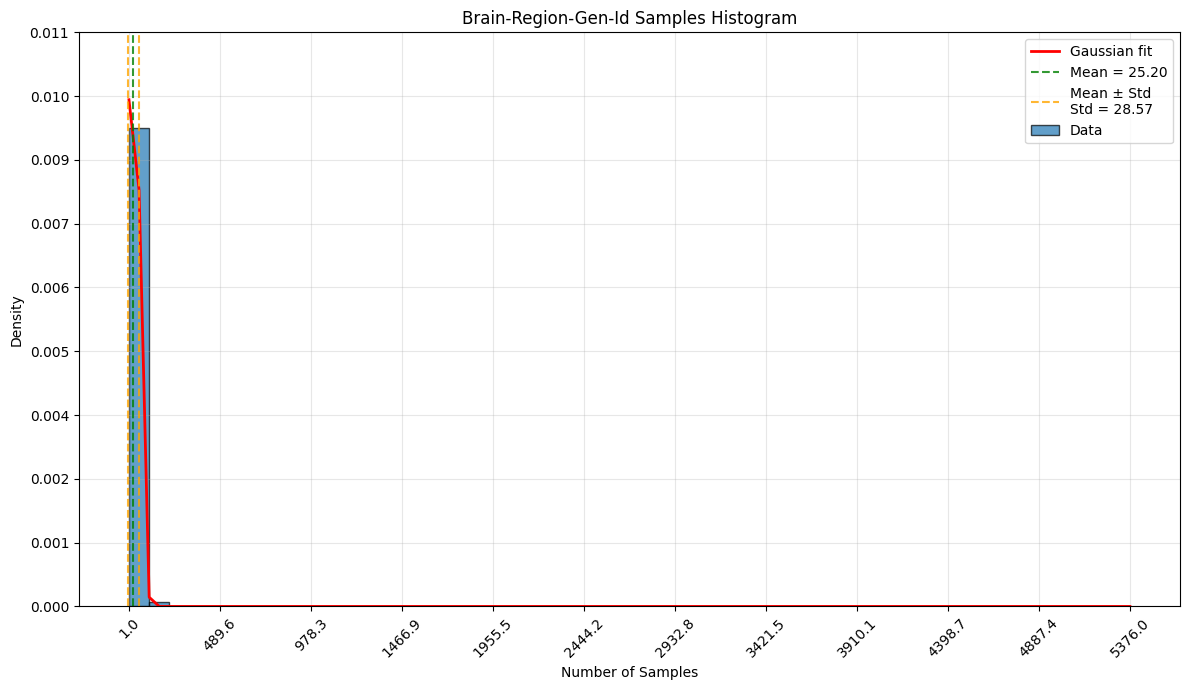

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
# Calculate statistics
mean = meta_donor_df['sample_count'].mean()
std = meta_donor_df['sample_count'].std()

# Create the histogram
plt.figure(figsize=(12, 7))

# Plot histogram with fewer bins and get the parameters for gaussian fit
counts, bins, _ = plt.hist(meta_donor_df['sample_count'], bins=50, density=True, 
                          alpha=0.7, edgecolor='black', label='Data')

# Generate points for the Gaussian curve
x = np.linspace(min(bins), max(bins), 100)
gaussian = norm.pdf(x, mean, std)

# Plot the Gaussian curve
plt.plot(x, gaussian, 'r-', lw=2, label='Gaussian fit')

# Add vertical lines for mean and mean ± std
plt.axvline(mean, color='g', linestyle='--', alpha=0.8, label=f'Mean = {mean:.2f}')
plt.axvline(mean + std, color='orange', linestyle='--', alpha=0.8, 
            label=f'Mean ± Std\nStd = {std:.2f}')
plt.axvline(mean - std, color='orange', linestyle='--', alpha=0.8)

# Add labels and title
plt.title('Brain-Region-Gen-Id Samples Histogram')
plt.xlabel('Number of Samples')
plt.ylabel('Density')

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend()

# Set y-axis limits and ticks
counts_max = np.max(counts)
plt.ylim(0, counts_max * 1.2)
yticks = np.linspace(0, counts_max * 1.2, 10)
plt.yticks(yticks)

# Set x-axis limits and ticks based on data range
data_min = meta_donor_df['sample_count'].min()
data_max = meta_donor_df['sample_count'].max()
xticks = np.linspace(data_min, data_max, 12)  # 12 evenly spaced ticks
plt.xticks(xticks, rotation=45)

# Format tick labels
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

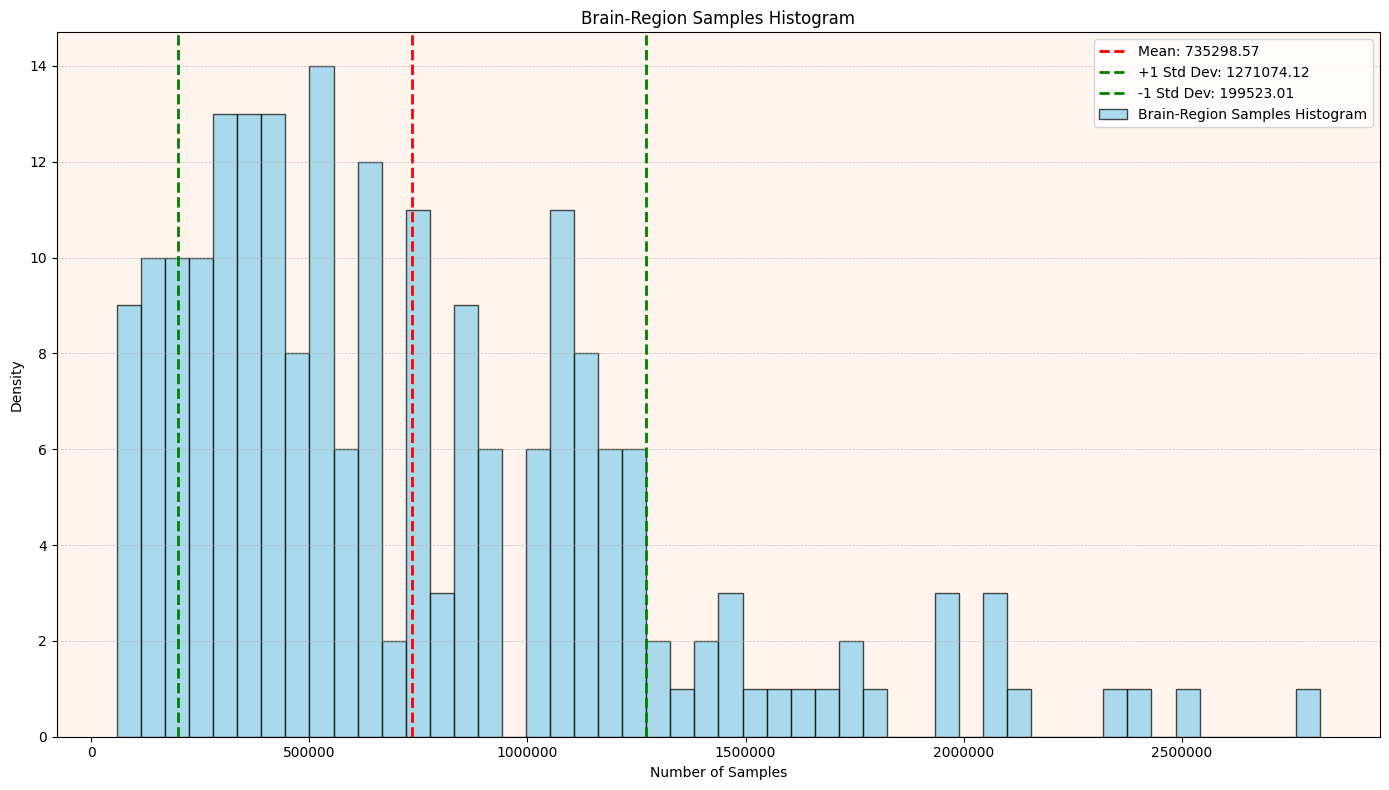

In [40]:
plot_histogram(number_of_samples_per_br, plot_title='Brain-Region Samples Histogram', x_title="Number of Samples", y_title="Density"
, bins=50)

In [ ]:
# def get_meta_donor_lists(pth: Path) -> Tuple[List[str], List[int], List[int], int]:
#     """
#         Export Brain Regions, Gene_Ids and Brain Samples Per Region Lists for plotting. 
#     """
#     # Lists to store information for plotting
#     brain_regions = []
#     gene_ids = []
#     samples_sizes_br = []
#     samples_sizes_br_ge = []
#     total_number_of_samples = 0

#     # Stream through the JSON file using ijson
#     with open(pth, "r") as f:
#         # Parse key-value pairs at the root level
#         for brain_region, genes in ijson.kvitems(f, ''):
#             logger.info(f"Brain Region: {brain_region}")  # Access the brain region key (e.g., "4012")
#             number_of_samples_per_brain_region = 0
#             for gene in genes:
#                 # Access gene_id
#                 gene_id = gene["gene_id"]
#                 gene_ids.append(gene_id)
                
#                 # Access gene_expression_values and convert to float if Decimal
#                 gene_expression_values = [float(val) if isinstance(val, Decimal) else val for val in gene["gene_expression_values"]]
#                 samples_sizes_br_ge.append(len(gene_expression_values))
#                 number_of_samples_per_brain_region+=len(gene_expression_values)

#                 # Calculate the total number of sample sizes
#                 total_number_of_samples+= len(gene_expression_values)

#             samples_sizes_br.append(number_of_samples_per_brain_region)
#             brain_regions.append(brain_region)
    
#     return brain_regions, gene_ids, samples_sizes_br, samples_sizes_br_ge, total_number_of_samples,      

# # EXP1 
#  # Path of the meta_donor data
# meta_donor_json_pth = PROCESSED_DONORS_GE_PATH / Path("meta_donor.json")
# brain_regions, brain_regions_gene_ids, samples_sizes_br, samples_sizes_br_ge, total_number_of_samples= get_meta_donor_lists(meta_donor_json_pth)

# gene_ids = list(set(brain_regions_gene_ids))

# logger.info(f"Number of Total Brain Regions: {len(brain_regions)}")
# logger.info(f"Number of Sample Sizes Calculated {len(samples_sizes_br)}")
# logger.info(f"Number of Gene Ids  {len(gene_ids)}")
# logger.info(f"Total Samples across all Brain Regions {total_number_of_samples}")
    
# # #Plots
# # plot_values(brain_regions, samples_sizes_br, "Number of Samples Per Brain Regions", 
# #                 "Brain Regions", "Number of Samples", True)

# # plot_histogram(samples_sizes_br, plot_title="Sample Size per Brain Region Histogram-20", 
# #                x_title="Sample Size Per Brain Region", y_title="Number of Brain Regions (Frequence)", bins=20, save=True)      
    



In [ ]:
# 11759550, 20355395, 19296753, 14957144, 1068697, 46375434,


In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Calculate sums by brain region
# region_sums = df.groupby('brain_region')['num_values'].sum()

# # Create the plot
# plt.figure(figsize=(12, 6))
# ax = region_sums.plot(kind='bar')

# # Customize the plot
# plt.title('Sum of Values by Brain Region', pad=20)
# plt.xlabel('Brain Region')
# plt.ylabel('Sum of Values')

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45, ha='right')

# # Add value labels on top of each bar
# for i, v in enumerate(region_sums):
#     ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# # Adjust layout to prevent label cutoff
# plt.tight_layout()

# # Show the plot
# plt.show()